# 3. Preparación de los datos y tarea de regresión

## 3.1 Preparación de los datos

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings

#utils data visualization
from utils.visualization import *
from utils.constants import *
from utils.plot_themes import *
from utils.model_utils import *

# Scikit-learn: preparación de los datos
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

import re
import unicodedata

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve


In [3]:
df = load_and_info('data/df_investig_INR.csv')

columnas_a_eliminar = ['Unnamed: 0']

if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=columnas_a_eliminar)

columnas_a_conservar = ['INR','HEMATOCRIT','IMC','HEMATIES','FREQ_CARDIACA','PCR','HEMOGLOBINA']

# Mantener solo las columnas que están en columnas_a_conservar
df = df[columnas_a_conservar]

df.info()


,Column,Dtype,Missing,Unique,Sample values
0,Unnamed: 0,int64,0,100,"[0, 1, 4, 5, 6]"
1,INR,float64,0,63,"[4.3, 2.8, 2.36, 2.53, 2.29]"
2,CALCI,float64,0,44,"[7.52, 8.54, 8.96, 9.12, 9.66]"
3,HEMOGLOBINA,float64,0,72,"[10.3, 12.24, 14.0, 7.75, 14.5]"
4,VCM,float64,0,82,"[95.7, 103.26, 95.5, 81.9, 88.65]"
5,HEMATOCRIT,float64,0,83,"[31.8, 36.65, 41.93, 37.22, 43.4]"
6,PLAQUETES,float64,0,81,"[192.0, 177.36, 168.33, 190.0, 417.0]"
7,DIAGNOSTIC_ASSOCIAT,object,0,4,"[FA_NE, EP_Other_No_CorPulm, FA_Cron, Flebitis..."
8,IMC,float64,0,84,"[27.33, 19.751666666666665, 24.94, 34.13, 24.88]"
9,HB_GLICOSILADA_A1C,float64,0,18,"[6.22, 8.0, 6.2, 6.3, 8.3]"



El juego de datos contiene 21 variables y 100 observaciones, de las cuales 0 son duplicadas.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   INR            100 non-null    float64
 1   HEMATOCRIT     100 non-null    float64
 2   IMC            100 non-null    float64
 3   HEMATIES       100 non-null    float64
 4   FREQ_CARDIACA  100 non-null    float64
 5   PCR            100 non-null    float64
 6   HEMOGLOBINA    100 non-null    float64
dtypes: float64(7)
memory usage: 5.6 KB


### División en las muestras de entrenamiento, validación, calibración y prueba

In [6]:
target_column = 'INR' 

categorical = df.select_dtypes(include=['object']).columns.tolist()
numerical = df.select_dtypes(include=['int64','float64']).columns.tolist()

X = df.drop(columns=[target_column])
y = df[target_column]

# X_train_full: 70% para Entrenamiento y Validación.
# X_test_full: 30% que contiene el Calibración y Prueba (el nuevo set completo de "test").
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, test_size=0.30, random_state=23)

# Paso 2: Dividir el 70% de entrenamiento (X_train_full) -> Entrenamiento (55%) y Validación (15%).
# El set de validación es 15% / 70% ≈ 0.21428 del conjunto X_train_full.
TEST_SIZE_VAL = 0.15 / 0.70

X_train, X_validate, y_train, y_validate = train_test_split(X_train_full, y_train_full, test_size=TEST_SIZE_VAL, random_state=23)

# Dividir el 30% restante de test (X_test_full) -> Calibración (15%) y Prueba (15%).
# Mismo tamaño, por lo que el test_size es 0.5 (la mitad).

# Nota: La convención original era test=20% y cal=80% del 25%, ahora son ambos 50% del 30%.
X_test, X_calibration, y_test, y_calibration = train_test_split(X_test_full, y_test_full, test_size=0.5, random_state=23)

### Codificación de las variables categóricas

In [7]:
# Listas con los nombres de las columnas categóricas
categorical = df.select_dtypes(exclude ='number').columns.tolist()

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # Usar handle_unknown
ohe = ColumnTransformer(
    transformers=[('ohe', encoder, categorical)],
    remainder='passthrough',
    verbose_feature_names_out=False
)
ohe.set_output(transform="pandas")
ohe.fit(X_train) # Ajustamos solo en Entrenamiento

X_train_processed = ohe.transform(X_train)
X_val_processed = ohe.transform(X_validate)
X_test_processed = ohe.transform(X_test)
X_cal_processed = ohe.transform(X_calibration)

### Imputación de valores ausentes

In [8]:
# Lista con los nombres de las columnas numéricas 
numerical = df.select_dtypes(include = 'number').columns.drop('INR').tolist()

In [9]:
total_ausentes = X_train_full.isnull().sum().sum()
print(f"\nTotal de valores ausentes en todo el set de entrenamiento: {total_ausentes}")


Total de valores ausentes en todo el set de entrenamiento: 0


### Escalado por estandarización

Escalamos ahora las variables numéricas, de modo que se pueda comparar la magnitud de cada característica. Aplicaremos estandarización con StandardScaler(), cuyo método fit() calcula la media y la desviación estándar del conjunto de entrenamiento y transform() se encarga de substraer la primera y dividir por la segunda a cada muestra. Se consigue así que para cada variable la media sea cero y la varianza uno. Este proceso también se acostumbra a llamar normalización, aunque el término puede referirse únicamente a una transformación diferente, como es en la forma de la distribución en vez de en el rango de valores.

In [10]:
# Estandarizamos el conjunto de entrenamiento
scaler = StandardScaler()

# Configuramos ahora ColumnTransformer para evitar las ya codificadas
norm = ColumnTransformer(
    transformers=[('norm', scaler, numerical)],
    remainder='passthrough', # keep any other columns unchanged
    verbose_feature_names_out=False
)
# La salida como dataframe
norm.set_output(transform="pandas")
norm.fit(X_train_processed) # Ajustamos solo en Entrenamiento procesado

X_train_scaled = norm.transform(X_train_processed)
X_val_scaled = norm.transform(X_val_processed) # Transformamos Validación

X_test_scaled = norm.transform(X_test_processed)
X_cal_scaled = norm.transform(X_cal_processed)


# 4. Entrenamiento de los modelos

### Arboles de decision

In [11]:
param_grid_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, 15, None],
    'min_samples_leaf': [5, 10, 20],
    'max_features': [0.5, 0.7, 1.0]
}

best_rf = bestHiperparamethers_randomizedSearchCV(param_grid_rf,RandomForestRegressor(random_state=23),X_train_scaled, y_train)

Iniciando ajuste de RandomForestRegressor(random_state=23)...


Mejores parámetros RF: {'n_estimators': 100, 'min_samples_leaf': 20, 'max_features': 0.7, 'max_depth': 10}


In [12]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Inicializar y ajustar el modelo (limitamos la profundidad para mantener la interpretabilidad)
dt_model = DecisionTreeRegressor(
    max_depth=7,            # Aumentar la profundidad a 7 (un buen compromiso)
    min_samples_leaf=5,     # Añadir una restricción de hoja para evitar sobreajuste extremo
    random_state=23
)

#evaluate_model(y_test, dt_pred,'Arboles de decisión')


In [13]:
# Modelo de Random Forest con hiperparámetros corregidos
# Los demás parámetros se mantienen fijos del tuning:
# n_estimators=500, min_samples_leaf=1, max_features=1.0
rf_model_regularized = RandomForestRegressor(
    n_estimators=500,
    min_samples_leaf=5,
    max_features=1.0,
    max_depth=None,      
    random_state=23,
    n_jobs=-1
)

## MEJOR MODELO

--- Evaluación: Random Forest ---
R² (Coeficiente de Determinación): -0.0778
RMSE (Error Cuadrático Medio): 0.2743
MAE (Error Absoluto Medio): 0.2012


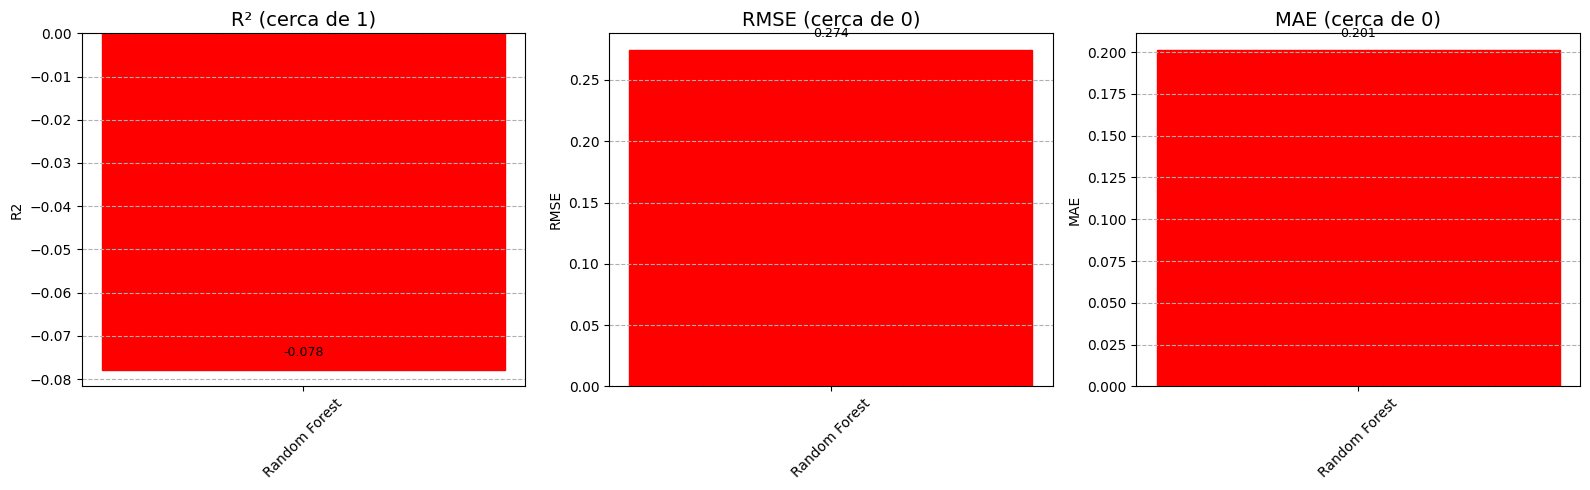

In [14]:
# 1. Crear las listas de modelos y nombres

rf_model_regularized.fit(X_train_scaled, y_train)

modelos_finales = [rf_model_regularized]
nombres_modelos = ['Random Forest']

# 2. Ejecutar la función para obtener la tabla de comparación
# Usamos el set de PRUEBA (X_test, y_test) para la evaluación final imparcial.
tabla_final_comparativa = evaluar_y_comparar_final(
    modelos=modelos_finales,
    nombres=nombres_modelos,
    X_test=X_test_scaled,
    y_test=y_test
)



plot_comparativa_final(tabla_final_comparativa)

### Shapley Additive Explanations (SHAP)

In [15]:
feature_names = numerical + categorical
feature_names
df_X_test = pd.DataFrame(X_test,columns=feature_names)

In [16]:
import shap
import pandas as pd
import numpy as np

# --- 1. Inicializar el Explicador SHAP ---
# Para modelos basados en árboles (Random Forest), se usa TreeExplainer, que es muy eficiente.
explainer = shap.TreeExplainer(rf_model_regularized)

# --- 2. Calcular Valores SHAP ---
# Calculamos los valores SHAP para todas las instancias en el conjunto de prueba
# (Esto puede tardar un poco dependiendo del tamaño de df_X_test)
shap_values = explainer.shap_values(df_X_test)

# --- 3. Obtener el valor base (Expected Value) ---
# El valor base es la predicción promedio del modelo en el dataset de entrenamiento/background
expected_value = explainer.expected_value

c:\Users\VALER\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


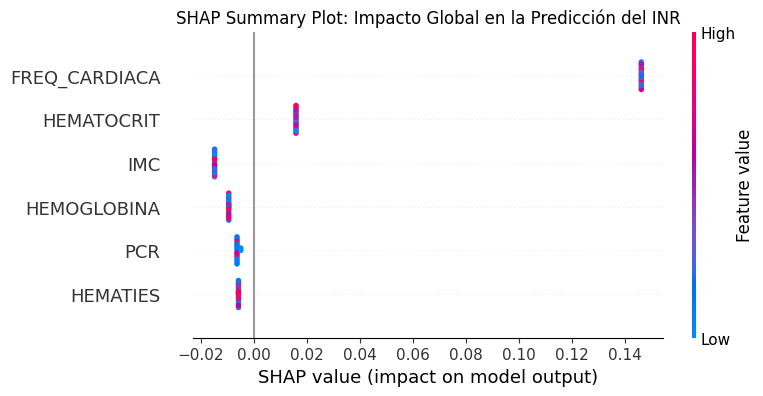

In [17]:
# --- Generar el Summary Plot ---
# Muestra las variables más importantes globalmente
shap.summary_plot(shap_values, df_X_test, show=False)
plt.title("SHAP Summary Plot: Impacto Global en la Predicción del INR")
plt.show()

### Cross-Validation Conformal Prediction (Jackknife+)

In [18]:
df_X_train = pd.DataFrame(X_train, columns=feature_names)

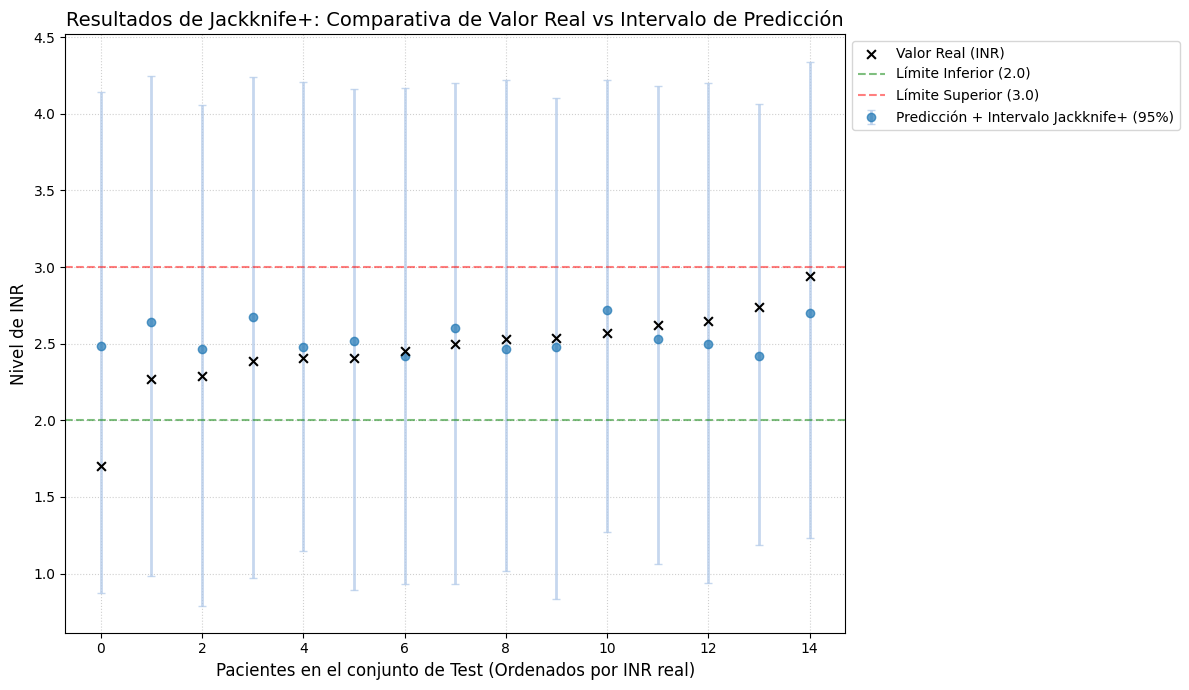

In [19]:
from mapie.regression import MapieRegressor
from sklearn.model_selection import KFold
from mapie.regression import MapieQuantileRegressor

# 2. Configurar MAPIE para Jackknife+ (Cross-Validation)
# cv=5 o cv=10 es lo estándar. 
# cv=KFold(...) nos permite controlar la aleatoriedad.

kf = KFold(n_splits=5, shuffle=True, random_state=23)

mapie_cv = MapieRegressor(
    estimator=rf_model_regularized, 
    cv=kf, 
    method="plus", # "plus" implementa Jackknife+
    n_jobs=-1
)

# 3. Entrenar (Aquí MAPIE entrena el RF 5 veces internamente)
# Usamos el set de entrenamiento completo (df_train)
mapie_cv.fit(df_X_train, y_train)

# 4. Predecir sobre el test set
alpha = 0.05
y_pred_cv, y_pis_cv = mapie_cv.predict(X_test, alpha=alpha)

# Extraer límites
y_lower_cv = y_pis_cv[:, 0, 0]
y_upper_cv = y_pis_cv[:, 1, 0]
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Organizamos los resultados para el gráfico
# Usamos y_pred_cv, y_lower_cv y y_upper_cv que generaste con mapie_cv
df_res_cv = pd.DataFrame({
    'Real': y_test,
    'Predicho': y_pred_cv,
    'Inferior': y_lower_cv,
    'Superior': y_upper_cv
}).sort_values(by='Real').reset_index(drop=True)

# 2. Configuración del gráfico
plt.figure(figsize=(12, 7))

# Dibujar los intervalos de predicción (las barras de error)
plt.errorbar(df_res_cv.index, df_res_cv['Predicho'], 
             yerr=[df_res_cv['Predicho'] - df_res_cv['Inferior'], 
                   df_res_cv['Superior'] - df_res_cv['Predicho']],
             fmt='o', color='#1f77b4', ecolor='#aec7e8', elinewidth=2, capsize=3,
             label='Predicción + Intervalo Jackknife+ (95%)', alpha=0.7)

# Dibujar los valores reales (puntos negros)
plt.scatter(df_res_cv.index, df_res_cv['Real'], color='black', marker='x', s=40, 
            label='Valor Real (INR)', zorder=5)

# 3. Líneas de referencia clínica (Rango Terapéutico Estándar)
plt.axhline(y=2.0, color='green', linestyle='--', alpha=0.5, label='Límite Inferior (2.0)')
plt.axhline(y=3.0, color='red', linestyle='--', alpha=0.5, label='Límite Superior (3.0)')

# 4. Estética
plt.title('Resultados de Jackknife+: Comparativa de Valor Real vs Intervalo de Predicción', fontsize=14)
plt.xlabel('Pacientes en el conjunto de Test (Ordenados por INR real)', fontsize=12)
plt.ylabel('Nivel de INR', fontsize=12)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()


In [20]:
# 1. Calcular el ancho de cada intervalo (Superior menos Inferior)
# Usamos tus variables y_upper_cv e y_lower_cv
anchos_cv = y_upper_cv - y_lower_cv

# 2. Calcular la métrica del Ancho Medio (Mean Interval Width)
ancho_medio_cv = anchos_cv.mean()

# 3. Calcular la Desviación Estándar de los anchos (mide la estabilidad/volatilidad)
estabilidad_ancho_cv = anchos_cv.std()

print(f"Ancho Medio del Intervalo (7 variables): {ancho_medio_cv:.4f}")
print(f"Estabilidad de los intervalos (Std Dev): {estabilidad_ancho_cv:.4f}")

Ancho Medio del Intervalo (7 variables): 3.1779
Estabilidad de los intervalos (Std Dev): 0.1230


### Diverse Counterfactual Explanations (DiCE)

In [21]:
df.head(100)

,INR,HEMATOCRIT,IMC,HEMATIES,FREQ_CARDIACA,PCR,HEMOGLOBINA
0,4.30,31.80,27.330000,3.32,90.000000,9.59,10.30
1,2.80,36.65,19.751667,3.55,73.857143,0.11,12.24
2,2.36,41.93,24.940000,4.45,75.500000,0.36,14.00
3,2.53,37.22,34.130000,4.49,71.375000,11.10,7.75
4,2.29,43.40,24.880000,5.14,67.900000,0.21,14.50
...,...,...,...,...,...,...,...
95,2.01,44.24,29.000000,4.97,77.000000,5.80,14.38
96,2.17,39.10,27.330000,4.24,71.000000,48.65,12.80
97,2.96,38.13,20.770000,4.04,74.000000,9.59,5.80
98,2.41,32.10,24.480000,3.49,61.000000,6.75,10.33


In [22]:
rf_model_regularized.predict(df_X_train).min()


2.653943666617268

In [23]:
import dice_ml
import warnings
warnings.filterwarnings('ignore', message='X has feature names')
# --- Asumir el Paciente a Explicar (Instancia de interés) ---
# Seleccionamos la primera instancia del set de prueba para el ejemplo.
instance_of_interest = df_X_test.iloc[0:1] 
# El valor de INR real (solo para contexto, DiCE solo usa el modelo)
actual_prediction = rf_model_regularized.predict(instance_of_interest)[0]

# --- Definir el Objetivo Deseado ---
# Si la predicción actual es alta (ej. 3.5), queremos encontrar contrafactuales para un INR bajo (ej. 2.5)
target_prediction_value = 1.0

df_train_dice = df_X_train.copy()
df_train_dice['INR'] = y_train
feature_names = [col for col in df_train_dice.columns if col != 'INR']

# --- Inicializar DiCE ---
# La librería DiCE requiere que le pases el modelo, los datos y los tipos de datos.
d = dice_ml.Data(dataframe=df_train_dice, continuous_features=feature_names, outcome_name='INR')
m = dice_ml.Model(model=rf_model_regularized, backend='sklearn', model_type='regressor')
exp = dice_ml.Dice(d, m, method='random') # Método rápido, también se puede usar 'genetic'

# --- Generar Explicaciones Contrafactuales ---
min_pred = rf_model_regularized.predict(df_X_train).min()

dice_explanation = exp.generate_counterfactuals(
    instance_of_interest,
    total_CFs=5,
    desired_range=[min_pred, min_pred + 0.3]
)

# 1. Generar el DataFrame de las explicaciones contrafactuales
cf_df = dice_explanation.visualize_as_dataframe()

100%|██████████| 1/1 [00:02<00:00,  2.28s/it]

Query instance (original outcome : 3.0)


,HEMATOCRIT,IMC,HEMATIES,FREQ_CARDIACA,PCR,HEMOGLOBINA,INR
0,38.400002,27.33,4.64,69.0,9.59,13.57,3.0



Diverse Counterfactual set (new outcome: [2.6539436666172684, 2.9539436666172683])


,HEMATOCRIT,IMC,HEMATIES,FREQ_CARDIACA,PCR,HEMOGLOBINA,INR
0,43.41,27.33,4.64,69.00,9.59,13.57,2.653944
1,38.40,27.33,4.64,69.00,9.59,12.93,2.653944
2,38.40,27.33,4.64,69.00,52.63,13.57,2.653944
3,30.74,27.33,4.64,89.19,9.59,13.57,2.653944
4,38.40,27.33,4.64,69.00,76.56,13.57,2.653944
